# Google Colab config

_**ignore if working locally**_

In [ ]:
!git clone https://github.com/Gaspard-a11y/ArcSong.git

In [ ]:
%cd ArcSong

In [ ]:
%pip install -r requirements.txt

# Experiments: Where do the NaNs come from?

In [1]:
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm #
from tqdm import tqdm

from modules.models import ArcModel
from modules.utils import load_json_dict
from modules.losses import SoftmaxLoss    

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_test = x_test/255.

In [3]:
# Define test batch
dataset_length = x_test.shape[0]
batch_size = 64
index = 377

test_batch = x_test[index:index+batch_size]
test_labels = y_test[index:index+batch_size]
# Adds channel dimension
test_batch = test_batch[...,np.newaxis]
test_batch.shape

(64, 28, 28, 1)

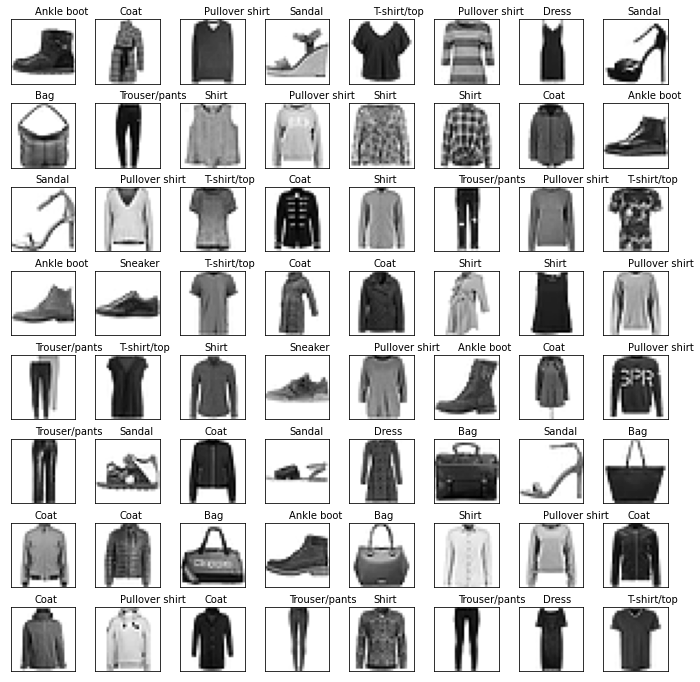

In [4]:
class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

def display_batch_64(test_batch, test_labels):
    n_rows, n_cols = 8, 8
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for n, (image, label) in enumerate(zip(test_batch, test_labels)):
        row = n // n_cols
        col = n % n_cols
        axes[row, col].imshow(image[:,:,0], cmap='binary')
        axes[row, col].get_xaxis().set_visible(False)
        axes[row, col].get_yaxis().set_visible(False)
        axes[row, col].text(10., -2.5, f'{class_names[label]}')
    plt.show()

display_batch_64(test_batch, test_labels)

## Finding a NaN output with tensorflow functions (not model)

In [5]:
from modules.models import Backbone, OutputLayer, NormHead, ArcHead 

In [6]:
# Config
input_size=28
channels=1
num_classes=10
name='arcface_model'
margin=0.5
logist_scale=64
embd_shape=2
head_type='ArcHead'
backbone_type='Custom'
use_pretrain=False
training=True
batch_size = 64

# Model functions
backbone = Backbone(backbone_type=backbone_type, use_pretrain=use_pretrain)
output_layer = OutputLayer(embd_shape)
archead = ArcHead(num_classes=num_classes, margin=margin, logist_scale=logist_scale)
normhead = NormHead(num_classes=num_classes)

# Loss function
loss_fn = SoftmaxLoss()

In [7]:
np.random.seed(1234)
tf.random.set_seed(1234)
random.seed(1234)

dataset_length = x_test.shape[0]
batchsize = 64

# Loop to find a k which outputs a NaN
for k in tqdm(range(dataset_length-batchsize-1)):
    # Define test batch
    test_batch = x_test[k:k+batch_size]
    test_labels = y_test[k:k+batch_size]
    test_batch = test_batch[..., np.newaxis]

    # Compute intermediary network values
    x = backbone(test_batch)
    embds = output_layer(x)

    arc_logits = archead(embds, test_labels)
    norm_logits = normhead(embds)

    if (np.isnan(np.mean(x.numpy())) or np.isnan(np.mean(embds.numpy())) or np.isnan(np.mean(arc_logits.numpy())) or np.isnan(np.mean(norm_logits.numpy())) or np.isnan(loss_fn(test_labels, arc_logits)) or np.isnan(loss_fn(test_labels, norm_logits))):
        index = k
        break

k = index

print(f"Batch: {k} -> {k+batch_size-1}")
print(f"mean(x): {np.mean(x.numpy())}")
print(f"mean(embds): {np.mean(embds.numpy())}")
print(f"mean(arc_logits): {np.mean(arc_logits.numpy())}")
print(f"mean(norm_logits): {np.mean(norm_logits.numpy())}")

print(f"Loss arc: {loss_fn(test_labels, arc_logits)}")
print(f"Loss norm: {loss_fn(test_labels, norm_logits)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9935/9935 [25:13<00:00,  6.57it/s]

Batch: 377 -> 440
mean(x): 0.007634334731847048
mean(embds): 0.1129385381937027
mean(arc_logits): -18.960582733154297
mean(norm_logits): 0.019761133939027786
Loss arc: 85.35680389404297
Loss norm: 2.2913036346435547


In [8]:
arc_logits

<tf.Tensor: shape=(64, 10), dtype=float32, numpy=
array([[-6.32989731e+01,  2.57149563e+01, -6.36388855e+01,
         2.80458603e+01,  2.23391094e+01, -1.84679661e+01,
        -8.36497688e+00, -6.06974449e+01, -4.02074318e+01,
        -2.90080910e+01],
       [-6.14270935e+01, -1.41471415e+01, -4.71475601e+01,
         5.67435646e+01,  1.39784498e+01, -5.12689171e+01,
        -4.44351273e+01, -6.08764000e+01, -2.74622774e+00,
         1.05726156e+01],
       [-6.39230499e+01,  7.06816483e+00, -5.87188721e+01,
         4.39248581e+01,  3.36560287e+01, -3.59009705e+01,
        -2.69057884e+01, -6.39873962e+01, -2.35294819e+01,
        -1.06761255e+01],
       [-5.46686096e+01,  9.49192524e-01, -5.60134544e+01,
         4.81772575e+01,  2.82927551e+01, -4.08059807e+01,
        -3.23388672e+01, -6.38152885e+01, -1.77264080e+01,
        -3.46314392e+01],
       [ 1.90225964e+01,  4.15902824e+01,  2.15634918e+01,
        -6.39995651e+01,  1.67193489e+01,  5.06687775e+01,
         6.07740440e

Inspecting arc_logits shows that a single NaN appears in the tensor, which then propagates forward to the loss, then (during training) backward to the whole network.

However this experiment is not replicable, even when fixing seeds: try to run the following cell multiple times. It yields different outputs every time, despite the "model" having been already called above and the "k" being the one we found to produce a NaN output:  

In [9]:
# Checking that this is the correct testing batch
np.testing.assert_almost_equal(test_batch, x_test[k:k+batch_size][..., np.newaxis])

# Compute the intermediary tensors on this batch
x = backbone(test_batch)
embds = output_layer(x)
arc_logits = archead(embds, test_labels)
norm_logits = normhead(embds)

print(f"Batch: {k} -> {k+batch_size-1}")
print(f"mean(x): {np.mean(x.numpy())}")
print(f"mean(embds): {np.mean(embds.numpy())}")
print(f"mean(arc_logits): {np.mean(arc_logits.numpy())}")
print(f"mean(norm_logits): {np.mean(norm_logits.numpy())}")

print(f"Loss arc: {loss_fn(test_labels, arc_logits)}")
print(f"Loss norm: {loss_fn(test_labels, norm_logits)}")

AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 34141 / 50176 (68%)
Max absolute difference: 1.
Max relative difference: 254.
 x: array([[[[0.       ],
         [0.       ],
         [0.       ],...
 y: array([[[[0.],
         [0.],
         [0.],...

I am not sure whether this instability comes from the fact that we are not using a Model object so that the weights are not initialized yet. Let's instead try to use the whole model:

## Finding a NaN output using the whole model

In [10]:
config_arc = load_json_dict("configs/test_arc.json")

model = ArcModel(input_size=config_arc['input_size'],
                    backbone_type=config_arc['backbone_type'],
                    num_classes=config_arc['num_classes'],
                    training=True)

In [11]:
np.random.seed(1234)
tf.random.set_seed(1234)
random.seed(1234)

dataset_length = x_test.shape[0]
batch_size = 64

# Loop to find a k which outputs a NaN
indexx = None
for j in tqdm(range(dataset_length-batch_size)):
    # Define test batch
    test_batch = x_test[j:j+batch_size]
    test_labels = y_test[j:j+batch_size]
    test_batch = test_batch[..., np.newaxis]

    logits = model((test_batch, test_labels))
    
    if np.isnan(np.mean(logits)):
        indexx = j
        break

if indexx is not None:
    j = indexx
    print(f"Batch: {j} -> {j+batch_size-1}")
    print(f"mean(logits): {np.mean(logits)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9936/9936 [02:39<00:00, 62.13it/s]


Here apparently no NaNs are outputted anymore, let's try to iterate over the Dataset object ... 

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train/255.
x_test = x_test/255.

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

y_train = tf.convert_to_tensor(y_train, tf.float32)
y_train = tf.expand_dims(y_train, axis=1)

y_test = tf.convert_to_tensor(y_test, tf.float32)
y_test = tf.expand_dims(y_test, axis=1)

batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, y_train), y_train))
train_dataset = train_dataset.batch(batch_size)#prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(((x_test, y_test), y_test))
test_dataset = test_dataset.batch(batch_size)#prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
output = None
for step, (inputs, labels) in tqdm(enumerate(train_dataset)):
    with tf.GradientTape() as tape:
        logits = model(inputs, training=True)
        loss = loss_fn(labels, logits)

    if np.isnan(np.mean(logits)) or np.isnan(loss):
        nan_batch, nan_labels = inputs, labels
        output = (nan_batch, nan_labels)

if output is not None:
    (nan_batch, nan_labels) = output
    print(np.isnan(np.mean(model(nan_batch))))

938it [00:19, 47.00it/s]


Doesn't return any NaNs, neither in the test dataset nor the training dataset.

Let's try to train the network but copy-pasting from the problematic script: (this is an exact copy of train2.py)

In [14]:
from tensorflow.keras.optimizers import Adam

from modules.utils import load_json_dict

config="configs/test_arc.json"
config = load_json_dict(config)

model = ArcModel(input_size=config['input_size'],
                        channels=1, 
                        name='Backbone_test',
                        backbone_type=config['backbone_type'],
                        num_classes=config['num_classes'],
                        head_type=config['head_type'],
                        embd_shape=config['embd_shape'],
                        training=True)

learning_rate = tf.constant(config['learning_rate'])
optimizer = Adam(learning_rate=learning_rate)
loss_fn = SoftmaxLoss()

# Manual loop
for epoch in range(config['epochs']):
    print(f"====== Begin epoch {epoch} / {config['epochs']} ======")

    for step, (inputs, labels) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logist = model(inputs, training=True)
            loss = loss_fn(labels, logist)

        #TODO delete this debug
        if step%10==0:
            print(f"Step: {step}, loss: {loss}")  

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print(f"End of epoch {epoch}, saving weights...")
    model.save_weights(ckpt_path+f"/e_{epoch}.ckpt")

print("============ Training done! ============")

====== Begin epoch 0 / 1 ======
Step: 0, loss: 81.15892791748047
Step: 10, loss: 40.07560348510742
Step: 20, loss: 37.01405334472656
Step: 30, loss: 43.01148986816406
Step: 40, loss: 36.39466857910156
Step: 50, loss: 36.918785095214844
Step: 60, loss: 31.87735939025879
Step: 70, loss: 34.73907470703125
Step: 80, loss: 34.389827728271484
Step: 90, loss: 24.79759979248047
Step: 100, loss: 26.715476989746094
Step: 110, loss: 24.320098876953125
Step: 120, loss: 28.407751083374023
Step: 130, loss: 29.68829917907715
Step: 140, loss: nan
Step: 150, loss: nan
Step: 160, loss: nan
Step: 170, loss: nan
Step: 180, loss: nan
Step: 190, loss: nan
Step: 200, loss: nan
Step: 210, loss: nan
Step: 220, loss: nan
Step: 230, loss: nan
Step: 240, loss: nan
Step: 250, loss: nan
Step: 260, loss: nan
Step: 270, loss: nan
Step: 280, loss: nan
Step: 290, loss: nan
Step: 300, loss: nan
Step: 310, loss: nan
Step: 320, loss: nan
Step: 330, loss: nan
Step: 340, loss: nan
Step: 350, loss: nan
Step: 360, loss: nan
S

NameError: name 'ckpt_path' is not defined

And sure enough, it yields nans. Let's try to isolate a minimal replicable bug:

In [104]:
from tensorflow.keras.optimizers import Adam

from modules.utils import load_json_dict

# Config
config="configs/test_arc.json"
config = load_json_dict(config)

# Dataset
batch_size=64
buffer_size=1000

(x_train, y_train), _ = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train/255.
x_train = x_train[..., np.newaxis]
y_train = tf.convert_to_tensor(y_train, tf.float32)
y_train = tf.expand_dims(y_train, axis=1)

train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, y_train), y_train))
# train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


# Model
model = ArcModel(input_size=config['input_size'],
                        channels=1, 
                        name='Backbone_test',
                        backbone_type=config['backbone_type'],
                        num_classes=config['num_classes'],
                        head_type=config['head_type'],
                        embd_shape=config['embd_shape'],
                        training=True)

# Model weight history
weight_dict = {}
grads_dict = {}
for variable in model.trainable_variables:
    weight_dict[variable.name] = []
    grads_dict[variable.name] = []
loss_history = []


learning_rate = tf.constant(config['learning_rate'])
optimizer = Adam(learning_rate=learning_rate)
loss_fn = SoftmaxLoss()


# Manual loop
for step, (inputs, labels) in tqdm(enumerate(train_dataset)):
    
    with tf.GradientTape() as tape:
        logist = model(inputs, training=True)
        loss = loss_fn(labels, logist)

    # Break if nan
    if np.isnan(np.mean(logits)) or np.isnan(loss):
        save_batch = inputs  
        break

    else:
        # Compute gradients
        grads = tape.gradient(loss, model.trainable_variables)
        
        # Save model weights
        for k, variable in enumerate(model.trainable_variables):
            weight_dict[variable.name].append(np.mean(np.abs(variable.read_value())))
            grads_dict[variable.name].append(np.mean(np.abs(grads[k])))
        # Save loss history
        loss_history.append(loss.numpy())

        # Apply gradients
        optimizer.apply_gradients(zip(grads, model.trainable_variables))



105it [00:05, 18.17it/s]


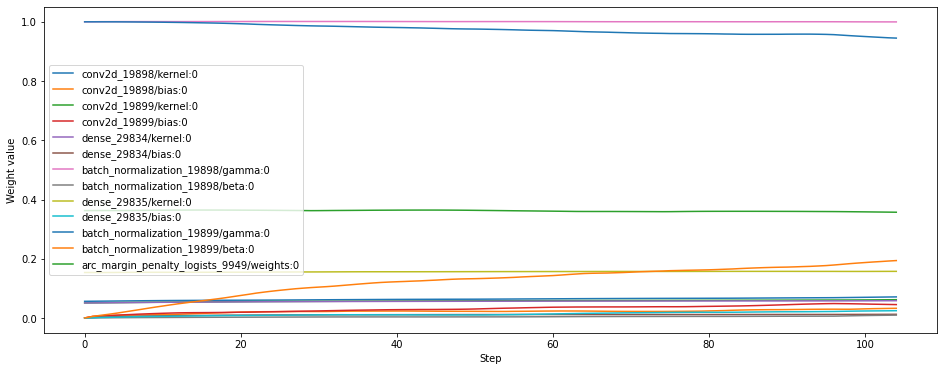

In [105]:
# Plot the evolution of the variables
plt.figure(figsize=(16,6))
for variable_name in weight_dict:
    value_list = weight_dict[variable_name]
    plt.plot(value_list, label=variable_name)
plt.xlabel("Step")
plt.ylabel("Weight value")
plt.legend()
plt.show()

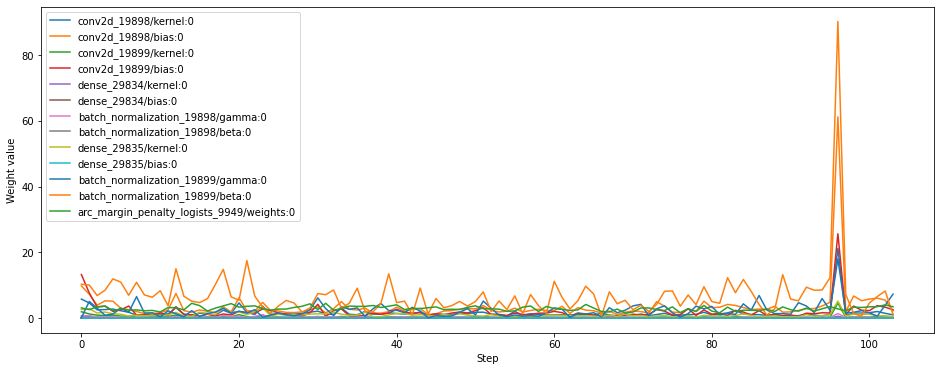

In [106]:
# Plot the evolution of the gradients
plt.figure(figsize=(16,6))
for variable_name in grads_dict:
    value_list = grads_dict[variable_name]
    plt.plot(value_list, label=variable_name)
plt.xlabel("Step")
plt.ylabel("Weight value")
plt.legend()
plt.show()

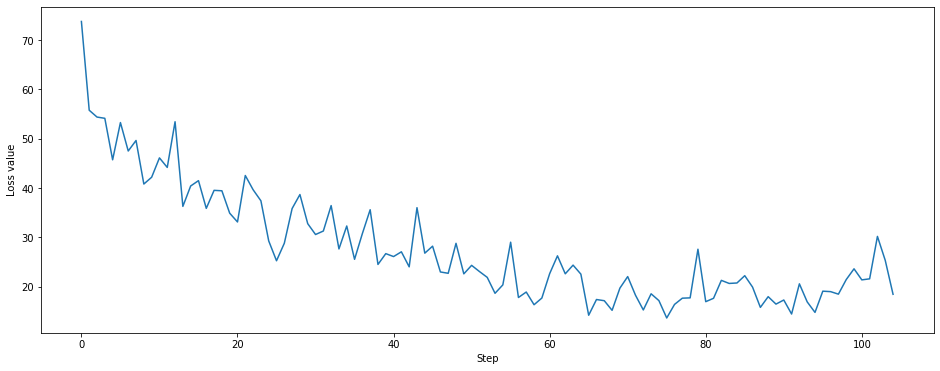

In [107]:
# Loss
plt.figure(figsize=(16,6))
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.show()

In [109]:
for variable_name in weight_dict:
    value_list = weight_dict[variable_name]
    print(f"{variable_name} : {value_list[-2]}")

conv2d_19898/kernel:0 : 0.07081649452447891
conv2d_19898/bias:0 : 0.03227987885475159
conv2d_19899/kernel:0 : 0.061532363295555115
conv2d_19899/bias:0 : 0.04564282298088074
dense_29834/kernel:0 : 0.05820188671350479
dense_29834/bias:0 : 0.012324020266532898
batch_normalization_19898/gamma:0 : 0.9997634887695312
batch_normalization_19898/beta:0 : 0.009254412725567818
dense_29835/kernel:0 : 0.15738189220428467
dense_29835/bias:0 : 0.02424384281039238
batch_normalization_19899/gamma:0 : 0.9460633993148804
batch_normalization_19899/beta:0 : 0.19230380654335022
arc_margin_penalty_logists_9949/weights:0 : 0.3573945462703705


In [110]:
for variable_name in grads_dict:
    value_list = weight_dict[variable_name]
    print(f"{variable_name} : {value_list[-2]}")

conv2d_19898/kernel:0 : 0.07081649452447891
conv2d_19898/bias:0 : 0.03227987885475159
conv2d_19899/kernel:0 : 0.061532363295555115
conv2d_19899/bias:0 : 0.04564282298088074
dense_29834/kernel:0 : 0.05820188671350479
dense_29834/bias:0 : 0.012324020266532898
batch_normalization_19898/gamma:0 : 0.9997634887695312
batch_normalization_19898/beta:0 : 0.009254412725567818
dense_29835/kernel:0 : 0.15738189220428467
dense_29835/bias:0 : 0.02424384281039238
batch_normalization_19899/gamma:0 : 0.9460633993148804
batch_normalization_19899/beta:0 : 0.19230380654335022
arc_margin_penalty_logists_9949/weights:0 : 0.3573945462703705


In [115]:
images, labels = save_batch
images.shape, labels.shape

(TensorShape([64, 28, 28, 1]), TensorShape([64, 1]))

In [116]:
model.trainable_variables

[<tf.Variable 'conv2d_19898/kernel:0' shape=(5, 5, 1, 16) dtype=float32, numpy=
 array([[[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan]],
 
         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan]],
 
         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan]],
 
         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan]],
 
         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan]]],
 
 
        [[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan]],
 
         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan]],
 
         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan]],
 
         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

# Testing just the Archead as a model, to see on what values it yields NaNs

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

from modules.models import ArcHead


In [3]:
embds = Input([2], name='embeddings')
labels = Input([], name='label')

logist = ArcHead(num_classes=2, margin=1, logist_scale=1)(embds, labels)
arc_model = Model((embds, labels), logist, name="arc_head")

arc_model.summary()

Model: "arc_head"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embeddings (InputLayer)        [(None, 2)]          0           []                               
                                                                                                  
 label (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 ArcHead (Functional)           (None, 2)            4           ['embeddings[0][0]',             
                                                                  'label[0][0]']                  
                                                                                                  
Total params: 4
Trainable params: 4
Non-trainable params: 0
_______________________________

In [4]:
# Dummy embeddings
embd_dim = 2
batch_size = 64
embeddings = np.random.normal(loc=0.0, scale=2.0, size=(batch_size,embd_dim))

#labels = np.zeros(shape=batch_size)
labels = np.ones(shape=batch_size)

embeddings = tf.convert_to_tensor(embeddings)
labels = tf.convert_to_tensor(labels)

In [5]:
logits = arc_model((embeddings,labels))

print(logits.shape)
logits

(64, 2)


<tf.Tensor: shape=(64, 2), dtype=float32, numpy=
array([[-5.4792428e-01, -3.6789683e-01],
       [-3.0863693e-01, -5.9936976e-01],
       [ 9.4224149e-01, -7.6620197e-01],
       [ 8.8885969e-01, -8.8607287e-01],
       [ 4.1273436e-01, -9.9481642e-01],
       [-5.9612256e-01, -3.9373916e-01],
       [-9.3647665e-01,  1.7089367e-01],
       [ 9.0212446e-01, -8.7173975e-01],
       [ 4.3577927e-01, -9.8668301e-01],
       [ 4.0218383e-05, -8.1715637e-01],
       [ 9.8420346e-01, -6.6379935e-01],
       [-8.9615256e-01,  1.5197089e-01],
       [ 9.4737232e-01, -7.5636268e-01],
       [-5.7054383e-01, -4.2251557e-01],
       [-4.3937069e-01, -4.8086327e-01],
       [-1.8822236e-01, -6.9404191e-01],
       [ 9.7731119e-01, -7.3037994e-01],
       [ 8.8045198e-01, -8.5362613e-01],
       [ 4.3752375e-01, -9.8699671e-01],
       [-2.3651068e-01, -7.2068202e-01],
       [-3.3314624e-01, -5.7846379e-01],
       [ 7.6182896e-01, -9.6833694e-01],
       [ 6.9809920e-01, -9.7012126e-01],
       [

In [134]:
embd_dim = 2
batch_size = 128

problematic_inputs=[] 

while len(problematic_inputs)<100:
    angles = np.random.uniform(low=0.0, high=2*np.pi, size=(batch_size,1))
    cosines, sines = np.cos(angles), np.sin(angles)
    
    embeddings = np.concatenate((cosines, sines), axis=1)
    # embeddings = np.random.normal(loc=0.0, scale=2.0, size=(batch_size,embd_dim))
    
    labels = np.random.randint(0, 2, size=batch_size)
    
    embeddings = tf.convert_to_tensor(embeddings)
    labels = tf.convert_to_tensor(labels)
    logits = arc_model((embeddings,labels))

    if np.isnan(np.mean(logits.numpy())):
        # Found a bad batch, finding the culprit...
        for k in range(batch_size):
            logit = arc_model((tf.expand_dims(embeddings[k], axis=0), tf.expand_dims(labels[k], axis=0))) 
            if np.isnan(np.mean(logit.numpy())):
                problematic_inputs.append((embeddings[k], labels[k]))
                print("+1")

KeyboardInterrupt: 

In [262]:
# Process the output into two groups
problematic_zeros = []
problematic_ones = []

for item in problematic_inputs:
    embeddings, labels = item
    if labels.numpy().astype(np.uint8)==0:
        problematic_zeros.append(embeddings.numpy())
    else:
        problematic_ones.append(embeddings.numpy())

problematic_zeros = np.array(problematic_zeros)
problematic_ones = np.array(problematic_ones)

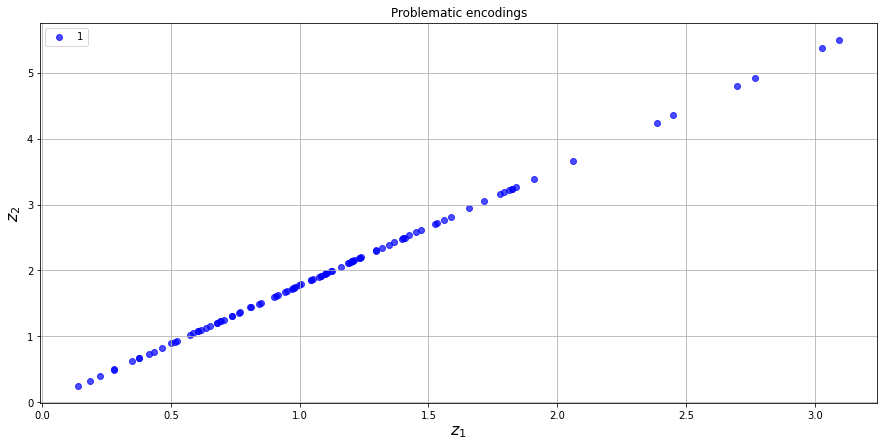

In [266]:
plt.figure(figsize=(15, 7))
cmap = cm.get_cmap('jet', 10)

#plt.scatter(problematic_zeros[:, 0], problematic_zeros[:, 1],
#                color=cmap(0), label="0", alpha=0.7)

plt.scatter(problematic_ones[:, 0], problematic_ones[:, 1],
                color=cmap(1), label="1", alpha=0.7)

plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Problematic encodings')
plt.legend()
plt.grid()
plt.show()

In [6]:
arc_model.summary()

Model: "arc_head"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embeddings (InputLayer)        [(None, 2)]          0           []                               
                                                                                                  
 label (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 ArcHead (Functional)           (None, 2)            4           ['embeddings[0][0]',             
                                                                  'label[0][0]']                  
                                                                                                  
Total params: 4
Trainable params: 4
Non-trainable params: 0
_______________________________

In [7]:
import math
# Simulating ArcMarginPenaltyLogists.call()

# self.params

margin = 0.5
logist_scale=64

cos_m = tf.identity(math.cos(margin), name='cos_m')
sin_m = tf.identity(math.sin(margin), name='sin_m')
th = tf.identity(math.cos(math.pi - margin), name='th')
mm = tf.multiply(sin_m, margin, name='mm')

# Weigths and tensors
w = arc_model.trainable_variables[0]
embds = tf.convert_to_tensor(problematic_ones[0])
labels = tf.convert_to_tensor(np.ones(1))

# Add batch dimension
embds = tf.expand_dims(tf.cast(embds, tf.float32), axis=0)
labels = tf.expand_dims(labels, axis=0)

NameError: name 'problematic_ones' is not defined

In [269]:
normed_embds = tf.nn.l2_normalize(embds, axis=1, name='normed_embd')
normed_w = tf.nn.l2_normalize(w, axis=0, name='normed_weights')
normed_embds, normed_w

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.49030927, 0.87154853]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-0.04058038,  0.49034163],
        [-0.99917626,  0.87153035]], dtype=float32)>)

In [272]:
cos_t = tf.matmul(normed_embds, normed_w, name='cos_t')
cos_t = tf.clip_by_value(cos_t, clip_value_min=-1, clip_value_max=1)

sin_t = tf.sqrt(1. - cos_t ** 2, name='sin_t')
cos_t, sin_t

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.8907275,  1.       ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.45453766, 0.        ]], dtype=float32)>)

In [274]:
cos_mt = tf.subtract(cos_t * cos_m, sin_t * sin_m, name='cos_mt')
# = cos(theta+m)
cos_mt

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.99960387,  0.87758255]], dtype=float32)>

In [250]:
# Magic, they do this in other implementations but I can't understand why
cos_mt = tf.where(cos_t > th, cos_mt, cos_t - mm)
cos_mt

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.87758255, -1.2393968 ]], dtype=float32)>

In [275]:
mask = tf.one_hot(tf.cast(labels, tf.int32), depth=2,
                  name='one_hot_mask')
mask

<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[0., 1.]]], dtype=float32)>

In [276]:
logists = tf.where(mask == 1., cos_mt, cos_t)
# = cos(theta+m) on label index, cos(theta) elsewhere
logists

<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[-0.8907275 ,  0.87758255]]], dtype=float32)>

In [277]:
logists = tf.multiply(logists, logist_scale, 'arcface_logist')
logists

<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[-57.00656 ,  56.165283]]], dtype=float32)>

# Training a dummy Archead model

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

from modules.models import ArcHead

In [226]:
# Define model
embds = Input([2], name='embeddings')
labels = Input([], name='label')

logist = ArcHead(num_classes=2, margin=1, logist_scale=1)(embds, labels)
model = Model((embds, labels), logist, name="arc_head")

model.summary()

Model: "arc_head"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embeddings (InputLayer)        [(None, 2)]          0           []                               
                                                                                                  
 label (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 ArcHead (Functional)           (None, 2)            4           ['embeddings[0][0]',             
                                                                  'label[0][0]']                  
                                                                                                  
Total params: 4
Trainable params: 4
Non-trainable params: 0
_______________________________

In [227]:
# Dataset
dataset_size=10000 
batch_size=64
epsilon = 0.1 # Overlapping classes

# Embeddings -> 0
angles0 = np.random.uniform(low=-np.pi/2-epsilon, high=np.pi/2+epsilon, size=(dataset_size//2,1))
cosines0, sines0 = np.cos(angles0), np.sin(angles0)
amplitudes = np.random.normal(loc=1.0, scale=0.1, size=(dataset_size//2,1))

embeddings0 = np.multiply(amplitudes, np.concatenate((cosines0, sines0), axis=1))
labels0 = np.zeros(shape=(dataset_size//2,1))

# Embeddings -> 1
angles1 = np.random.uniform(low=np.pi/2-epsilon, high=3*np.pi/2+epsilon, size=(dataset_size//2,1))
cosines1, sines1 = np.cos(angles1), np.sin(angles1)
amplitudes = np.random.normal(loc=1.0, scale=0.1, size=(dataset_size//2,1))

embeddings1 = np.multiply(amplitudes, np.concatenate((cosines1, sines1), axis=1))
labels1 = np.ones(shape=(dataset_size//2,1))

# Embeddings and labels
embeddings = np.concatenate((embeddings0, embeddings1), axis=0)
labels = np.concatenate((labels0, labels1), axis=0)

# Dataset object
train_dataset = tf.data.Dataset.from_tensor_slices(((embeddings, labels), labels))
train_dataset = train_dataset.shuffle(10)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [228]:
from tensorflow.keras.optimizers import Adam

learning_rate = tf.constant(5e-3)
optimizer = Adam(learning_rate=learning_rate)
loss_fn = SoftmaxLoss()

weights_history = []
loss_history = []
grads_history = []

# Manual loop
for step, (inputs, labels) in tqdm(enumerate(train_dataset)):
    with tf.GradientTape() as tape:
        logist = model(inputs, training=True)
        loss = loss_fn(labels, logist)
    # Compute gradients
    grads = tape.gradient(loss, model.trainable_variables)

    # Update histories
    weights_history.append(model.trainable_weights[0].numpy())
    loss_history.append(loss.numpy())
    grads_history.append(grads[0].numpy())
    
    # Apply gradients
    optimizer.apply_gradients(zip(grads, model.trainable_variables))



157it [00:01, 113.12it/s]


In [229]:
len(weights_history), len(loss_history), len(grads_history)

(157, 157, 157)

In [230]:
for k in range(157):
    print(f"Weights: \n {weights_history[k]} \n -> loss: {loss_history[k]} \n -> grads: \n {grads_history[k]} \n")

Weights: 
 [[-0.28104138  1.1864532 ]
 [ 0.07770848  0.5976527 ]] 
 -> loss: 1.6171971559524536 
 -> grads: 
 [[-0.0360527   0.09430477]
 [-0.13038921 -0.18721282]] 

Weights: 
 [[-0.27604184  1.1814533 ]
 [ 0.08270836  0.6026526 ]] 
 -> loss: 1.5959270000457764 
 -> grads: 
 [[-0.06208801  0.07224438]
 [-0.2072208  -0.14162941]] 

Weights: 
 [[-0.27114236  1.1765311 ]
 [ 0.08764149  0.6075694 ]] 
 -> loss: 1.6839847564697266 
 -> grads: 
 [[-0.10308695  0.02738139]
 [-0.31892788 -0.05302288]] 

Weights: 
 [[-0.2663572   1.1721056 ]
 [ 0.09249682  0.6119808 ]] 
 -> loss: 1.6514513492584229 
 -> grads: 
 [[-0.11295962  0.05793417]
 [-0.32528257 -0.11095937]] 

Weights: 
 [[-0.26149994  1.1675837 ]
 [ 0.09741625  0.61647946]] 
 -> loss: 1.656222939491272 
 -> grads: 
 [[-0.0602026   0.07059595]
 [-0.16160703 -0.13370536]] 

Weights: 
 [[-0.2567168   1.1629325 ]
 [ 0.10219889  0.6211033 ]] 
 -> loss: 1.6970840692520142 
 -> grads: 
 [[ 0.00079823  0.08045176]
 [ 0.00200546 -0.150635  ]] 


# Loading a model and computing the embeddings

In [2]:
# Load test dataset

batch_size=64
shuffle=True
buffer_size=1000


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_test = x_test/255.

In [3]:
# Load configs

config_norm = load_json_dict("configs/test_norm.json")
config_arc = load_json_dict("configs/test_arc.json")

In [4]:
model_norm = ArcModel(input_size=config_norm['input_size'],
                        channels=1, 
                        name='Backbone_test',
                        backbone_type=config_norm['backbone_type'],
                        num_classes=config_norm['num_classes'],
                        head_type=config_norm['head_type'],
                        embd_shape=config_norm['embd_shape'],
                        training=False)

model_arc = ArcModel(input_size=config_arc['input_size'],
                        channels=1, 
                        name='Backbone_test',
                        backbone_type=config_arc['backbone_type'],
                        num_classes=config_arc['num_classes'],
                        head_type=config_arc['head_type'],
                        embd_shape=config_arc['embd_shape'],
                        training=False)

In [5]:
# Load model weights

ckpt_path_norm = tf.train.latest_checkpoint('./checkpoints/' + config_norm['ckpt_name'])
if ckpt_path_norm is not None:
    model_norm.load_weights(ckpt_path_norm)

    
ckpt_path_arc = tf.train.latest_checkpoint('./checkpoints/' + config_arc['ckpt_name'])
if ckpt_path_arc is not None:
    model_arc.load_weights(ckpt_path_arc)


In [6]:
embeddings_norm = model_norm(x_test).numpy()
embeddings_arc = model_arc(x_test).numpy()

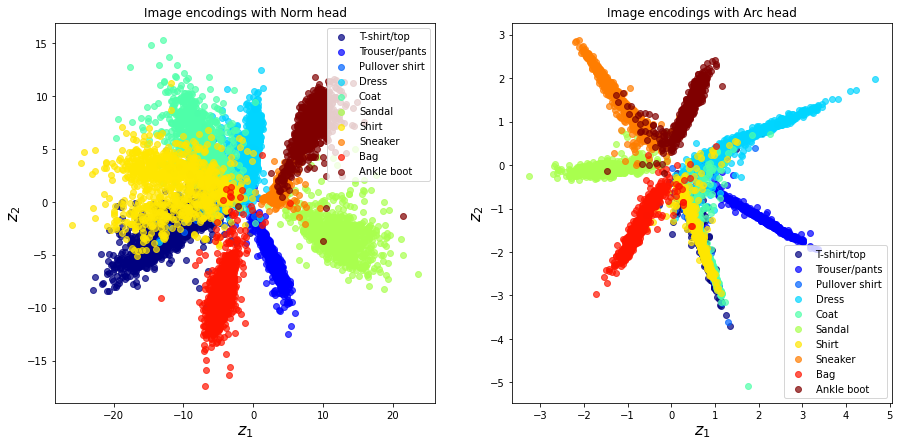

In [7]:
# Plot untrained and trained encodings

class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

plt.figure(figsize=(15, 7))
cmap = cm.get_cmap('jet', 10)

plt.subplot(1, 2, 1)
for i, class_label in enumerate(class_names):
    inx = np.where(y_test == i)[0]
    plt.scatter(embeddings_norm[inx, 0], embeddings_norm[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Image encodings with Norm head')
plt.legend()

plt.subplot(1, 2, 2)
for i, class_label in enumerate(class_names):
    inx = np.where(y_test == i)[0]
    plt.scatter(embeddings_arc[inx, 0], embeddings_arc[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Image encodings with Arc head')
plt.legend()

plt.show()